## Validation of Luminosity Equation and Subsequent Data Clustering
### Jeremy Kazimer
### 6/20/2021

#### _Import Statements_

We begin by making our import statements.  These are crucial in running the code. As such, if any of these libraries are missing please use `pip` or `pip3` to install them.

In [3]:
# Data Structures:
import pandas as pds
import numpy as np

# Plotting:
from matplotlib import pyplot as plt

#### _Loading the Data_

The data for this particular experiment can be found from [this page](https://www.astro.keele.ac.uk/jkt/debcat/).  Basically, John Southworth has collected a handful of binary star systems and their respective properties.   This include, but are not limited to,
* $\log T_{eff}$ -> the log temperature of the star
* $\log R'$ -> the log radius of the star
* $\log M'$ -> the log mass of the star

The rest, of course, can be found on the website.  Note that all of these properties are relative to the Sun such that, for example,

$$\log R' = \log\dfrac{R_a}{R_{sun}}$$

where $R_a$ is the actual radius and $R_{sun}$ is the radius of the sun.  This allows for information to not overflow, but any of the actual values can be retrieved since the proportion is unitless. The exception is $T_{eff}$, which is the effective temperature [as defined here](https://en.wikipedia.org/wiki/Effective_temperature).

Regardless, we can continue the section by loading the data in a dataframe:

In [4]:
debcat_df = pds.read_csv('https://www.astro.keele.ac.uk/jkt/debcat/debs.dat', delimiter = '\s+')

The `delimiter = '\s+'` flag is specifying that the data is separated by an inconsistent number of spaces.  However, the dataframe is a bit corrupted, as we can observe:

In [8]:
# head displays the first few rows of the dataframe
debcat_df.head()

,#,System,SpT1,SpT2,P(d),V,B-V,log(M1),error,log(M2),...,log(Teff1),err,log(Teff2),err.1,log(L1),error.6,log(L2),error.7,[M/H],error.8
0,EPIC_203710387,M4.5V,M5V,2.809,14.30,1.80,-0.9363,0.0116,-0.9763,0.0111,...,0.011,3.483,0.011,-1.842,0.047,-1.861,0.047,-9.99,-9.99,NaN
1,NGTS_J052218.2-250710.4,M5_V,M5_V,1.748,16.88,1.49,-0.7597,0.0032,-0.7590,0.0032,...,0.014,3.477,0.012,-9.990,-9.990,-9.990,-9.990,-9.99,-9.99,NaN
2,CM_Dra,M4.5_V,M4.5_V,1.268,12.90,1.60,-0.6364,0.0017,-0.6694,0.0018,...,0.010,3.494,0.014,-2.258,0.038,-2.313,0.056,-0.30,0.12,NaN
3,UScoCTIO_5,M4.5_V,M4.5_V,34.001,16.19,1.62,-0.4694,0.0026,-0.4864,0.0027,...,0.013,3.513,0.013,-1.105,0.053,-1.146,0.059,-9.99,-9.99,NaN
4,LSPM_J1112+7626,M4_V,none,41.033,14.85,1.49,-0.4038,0.0025,-0.5615,0.0019,...,0.024,3.470,0.023,-1.920,0.080,-2.210,0.090,-9.99,-9.99,NaN


The issue here is that the data has been improperly formatted because `# System` ahould be a string without whitespaces, but since there exists a whitespace `pandas` believes that they should be separate columns.  We can fix this rather easily:

In [9]:
# adj_df is shorthand for adjusted dataframe
# shift(1, axis = 1) moves everything one to the right and drops the values of the last column
adj_df = debcat_df.shift(1, axis = 1)

# We drop the pound sign column because we don't need it.
adj_df = adj_df.drop(['#'], axis = 1)

In [10]:
adj_df.head()

,System,SpT1,SpT2,P(d),V,B-V,log(M1),error,log(M2),error.1,...,log(Teff1),err,log(Teff2),err.1,log(L1),error.6,log(L2),error.7,[M/H],error.8
0,EPIC_203710387,M4.5V,NaN,2.809,14.30,1.80,-0.9363,0.0116,-0.9763,0.0111,...,3.483,0.011,3.483,0.011,-1.842,0.047,-1.861,0.047,-9.99,-9.99
1,NGTS_J052218.2-250710.4,M5_V,NaN,1.748,16.88,1.49,-0.7597,0.0032,-0.7590,0.0032,...,3.476,0.014,3.477,0.012,-9.990,-9.990,-9.990,-9.990,-9.99,-9.99
2,CM_Dra,M4.5_V,NaN,1.268,12.90,1.60,-0.6364,0.0017,-0.6694,0.0018,...,3.496,0.010,3.494,0.014,-2.258,0.038,-2.313,0.056,-0.30,0.12
3,UScoCTIO_5,M4.5_V,NaN,34.001,16.19,1.62,-0.4694,0.0026,-0.4864,0.0027,...,3.515,0.013,3.513,0.013,-1.105,0.053,-1.146,0.059,-9.99,-9.99
4,LSPM_J1112+7626,M4_V,NaN,41.033,14.85,1.49,-0.4038,0.0025,-0.5615,0.0019,...,3.486,0.024,3.470,0.023,-1.920,0.080,-2.210,0.090,-9.99,-9.99


Now, you can see that the data is exactly how we would anticipate.  For cleanliness sake, we can remove a few more columns that we certainly wouldn't use and we can also restructure the data so that it's in a more reasonable form for our assumptions:

In [12]:
# First, remove the error columns by getting the keys:
df_keys = adj_df.keys()

# This gives us the location of any string in the keys such that it has 'err' in it.
locs = (-np.core.defchararray.find(np.array(df_keys).astype(str), "err")).astype(bool)

# Then, we just save the dataframe where these keys don't exist.
adj_df = adj_df[df_keys[locs]]

In [13]:
adj_df.head()

,System,SpT1,SpT2,P(d),V,B-V,log(M1),log(M2),log(R1),log(R2),log_g1,log_g2,log(Teff1),log(Teff2),log(L1),log(L2),[M/H]
0,EPIC_203710387,M4.5V,NaN,2.809,14.30,1.80,-0.9363,-0.9763,-0.3648,-0.3730,4.2310,4.2070,3.483,3.483,-1.842,-1.861,-9.99
1,NGTS_J052218.2-250710.4,M5_V,NaN,1.748,16.88,1.49,-0.7597,-0.7590,-0.6893,-0.6639,5.0570,5.0070,3.476,3.477,-9.990,-9.990,-9.99
2,CM_Dra,M4.5_V,NaN,1.268,12.90,1.60,-0.6364,-0.6694,-0.5962,-0.6205,4.9940,5.0090,3.496,3.494,-2.258,-2.313,-0.30
3,UScoCTIO_5,M4.5_V,NaN,34.001,16.19,1.62,-0.4694,-0.4864,-0.0588,-0.0770,4.0859,4.1053,3.515,3.513,-1.105,-1.146,-9.99
4,LSPM_J1112+7626,M4_V,NaN,41.033,14.85,1.49,-0.4038,-0.5615,-0.4134,-0.5261,4.8610,4.9290,3.486,3.470,-1.920,-2.210,-9.99


In [14]:
# Now, remove the non-error columns we won't use:
if (adj_df.keys == np.array(['System', 'SpT2', '[M/H]'])).sum() != 0:
    adj_df = adj_df.drop(['SpT1', 'SpT2', '[M/H]'], axis = 1)

In [15]:
adj_df.head()

,System,SpT1,SpT2,P(d),V,B-V,log(M1),log(M2),log(R1),log(R2),log_g1,log_g2,log(Teff1),log(Teff2),log(L1),log(L2),[M/H]
0,EPIC_203710387,M4.5V,NaN,2.809,14.30,1.80,-0.9363,-0.9763,-0.3648,-0.3730,4.2310,4.2070,3.483,3.483,-1.842,-1.861,-9.99
1,NGTS_J052218.2-250710.4,M5_V,NaN,1.748,16.88,1.49,-0.7597,-0.7590,-0.6893,-0.6639,5.0570,5.0070,3.476,3.477,-9.990,-9.990,-9.99
2,CM_Dra,M4.5_V,NaN,1.268,12.90,1.60,-0.6364,-0.6694,-0.5962,-0.6205,4.9940,5.0090,3.496,3.494,-2.258,-2.313,-0.30
3,UScoCTIO_5,M4.5_V,NaN,34.001,16.19,1.62,-0.4694,-0.4864,-0.0588,-0.0770,4.0859,4.1053,3.515,3.513,-1.105,-1.146,-9.99
4,LSPM_J1112+7626,M4_V,NaN,41.033,14.85,1.49,-0.4038,-0.5615,-0.4134,-0.5261,4.8610,4.9290,3.486,3.470,-1.920,-2.210,-9.99


Now that our data is in the form that we want, we can begin actual analysis.

#### _The Luminosity Equation_

To begin with something simple, the luminosity $L$ of an object with surface area $A$ and temperature $T$ is given by

$$L = \sigma A T^4$$

such that $\sigma$ is the Stefan-Boltzmann constant.  We can work with this equation, but there must be some changes.  Namely, $L \to \log L'$, $T \to \log T_{eff}$, $A \to \log(A')$ (because surface area is a function of $R$, something in the logspace here also).  Or, really, variables relative to the Sun, in logspace.  We can begin by taking the log of both sides: 

$$\log(L = \sigma A T^4) \leftrightarrow \log(L) = \log(\sigma A T^4)$$

Using simple log rules, namely the multiplication rule such that $\log(xy) = \log(x) + \log(y)$, we can rewrite this equation such that:

$$\log(L) = \log(\sigma A T^4) \leftrightarrow \log(L) = \log(\sigma A) + \log(T^4)$$

Note that

$$\log(T^4) = 4\log(T)$$

bringing our equation to  

$$\log(L) = \log(\sigma A) + \log(T^4) \leftrightarrow \log(L) = \log(\sigma A) + 4\log(T)$$

However, we're not done.  We still need to make the simple conversions as mentioned before:

$$\log(L) = \log(\sigma A) + 4\log(T) \leftrightarrow \log(L') = \log(\sigma A') + 4\log(T_{eff})$$

Noticeably, this takes on the form of a linear equation $y = sx + b$ with slope $s$ and $y$-intercept $b$.  Therefore:
* $y = \log(L')$
* $x = \log(T_{eff})$
* $s = 4$
* $b = \log(\sigma A')$

As such, if we plot the data, we should observe this.  First, we must remove data earmarked by $-9.99$.  The website specifies that this is incorrect data:

In [16]:
for key in ['log(Teff1)', 'log(Teff2)', 'log(L1)', 'log(L2)']:
    adj_df = adj_df[adj_df[key] != -9.99]

In [17]:
log_L1 = adj_df['log(L1)']
log_L2 = adj_df['log(L2)']
log_L = np.concatenate((log_L1, log_L2))

In [18]:
log_T1 = adj_df['log(Teff1)']
log_T2 = adj_df['log(Teff2)']
log_T = np.concatenate((log_T1, log_T2))

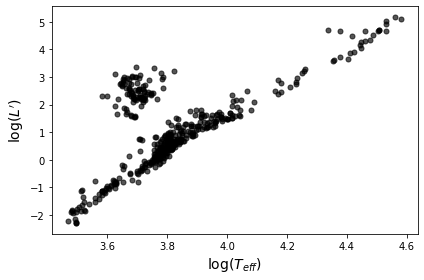

In [19]:
fig, ax = plt.subplots(1, 1)

ax.scatter(log_T, log_L, s = 25, c = 'k', alpha = 2/3)

ax.set_xlabel('$\log(T_{eff})$', fontsize = 14)
ax.set_ylabel('$\log(L\')$', fontsize = 14)

fig.tight_layout()

Noticeably, there is a cluster that exists off of the line.  That, well, can't be right...right? Let's try a linear fit.  Maybe it'll work out.

In [20]:
s, b = np.polyfit(log_T, log_L, 1)

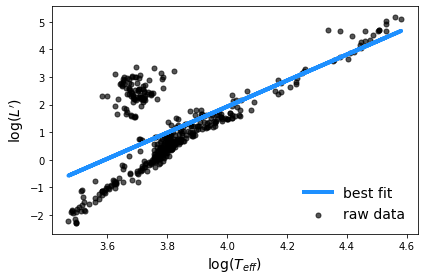

In [21]:
fig, ax = plt.subplots(1, 1)

ax.scatter(log_T, log_L, s = 25, c = 'k', alpha = 2/3, label = 'raw data')
ax.plot(log_T, log_T*s + b, lw = 4, c = 'dodgerblue', label = 'best fit')

ax.set_xlabel('$\log(T_{eff})$', fontsize = 14)
ax.set_ylabel('$\log(L\')$', fontsize = 14)
ax.legend(loc = 'lower right', fontsize = 14, frameon = False)

fig.tight_layout()

Yeah.  This is clearly incorrect.  There exists something going on with that data not specified in the original website.  So, without any background knowledge, we can't precisely say what's going on.  But, we can implement a clustering algorithm to separate the two sets of data!

#### _Separation Algorithm_

One of many algorithms by which to separate these clusters can be found by simply iteratively calculating the line parameters and then removing the points that fall outside of an error margin.  Once those points have been removed, we can recalculate the line parameters and repeat the process until the error is minimized.  Or, in a more compact algorithm:
1. intialize the data
2. calculate the line of best fit
3. remove points that do not fit to this data
4. repeat (1 - 3) until the aggregate error is minimized

In examining this in a machine learning lens, this is really just minimizing the loss function.  Our loss function would then be

$$\epsilon = \sum(y - \hat{y})^2$$

where $\epsilon$ is the loss and $\hat{y}$ is the prediction.  We can create a function to do just this:

$$\epsilon = |L_{true} - L_{predict}|$$

In [22]:
def minimize_error(log_Teff, log_L, threshold = 1, err_max = 1, k_max = 1000):
    
    '''
        log_Teff -> the initialization of X data
        log_L -> the initialization of Y data
        threshold -> the scalar by which to cut off incorrect predictions
        mse_max -> the maximum mean-square error differential before exiting the while loop
        k_max -> the number of iterations before exiting the loop
    '''
    
    # The current data points.  We intialize it with the inputs.
    curr_x = log_Teff
    curr_y = log_L
    
    # The current and previous mean squared errors of the process.
    curr_mse = 0
    prev_mse = np.inf
    
    # The starting iterator.
    k = 0
    
    while abs(curr_mse - prev_mse) > err_max:
        
        # Check to make sure that we haven't exceeded the number of iterations.
        if k > k_max:
            print('Too many iterations.  Algorithm did not converge.')
            return None
        
        # Assign the previous mse to a new value.
        prev_mse = curr_mse
        
        # Find the line coefficients of the current data.
        s, b = np.polyfit(curr_x, curr_y, 1)
        
        # Calculate the error relative to the input data.
        err = (log_L - (s*log_Teff + b))
        curr_mse = np.sum(err)**2
    
        # Find the location where this is accurate for our estimates.
        indices = abs(err) < threshold
        
        # Make sure that the threshold is OK.
        if len(indices) == 0:
            print('Error margin too small.  Algorithm did not converge.')
            return None
        
        # Change the current variables to be the new indices.
        curr_x = log_Teff[indices]
        curr_y = log_L[indices]
        
        # Increment k by 1 and repeat.
        k += 1
    
    # Make sure that the error maximum hasn't been set insanely high.
    if k > 0:
        print('Algorithm converged successfully.')
        return s, b, indices
    
    else:
        print('MSE error maximum too large.  Algorithm did not converge.')
        return None

So, now that the function has been made, let's try it with the intial parameters:

In [23]:
s, b, indices = minimize_error(log_T, log_L)

Algorithm converged successfully.


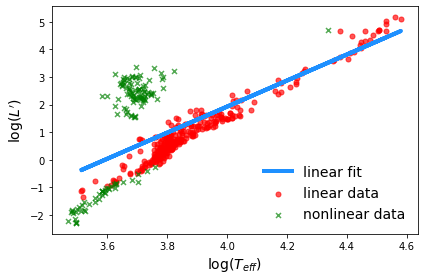

In [24]:
fig, ax = plt.subplots(1, 1)

ax.scatter(log_T[indices], log_L[indices], s = 25, c = 'red', alpha = 2/3, label = 'linear data')
ax.scatter(log_T[~indices], log_L[~indices], s = 25, c = 'green', marker = 'x', alpha = 2/3, label = 'nonlinear data')

ax.plot(log_T[indices], log_T[indices]*s + b, lw = 4, c = 'dodgerblue', label = 'linear fit')

ax.set_xlabel('$\log(T_{eff})$', fontsize = 14)
ax.set_ylabel('$\log(L\')$', fontsize = 14)
ax.legend(loc = 'lower right', fontsize = 14, frameon = False)

fig.tight_layout()

Better, but clearly not perfect.  Let's try tweaking those parameters.

In [25]:
s, b, indices = minimize_error(log_T, log_L, err_max = 0.01, threshold = 0.4)

Algorithm converged successfully.


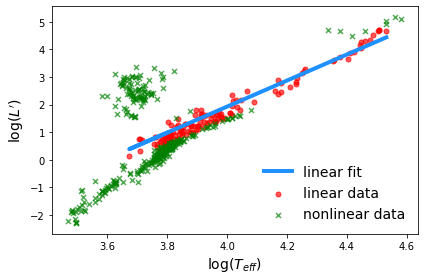

In [26]:
fig, ax = plt.subplots(1, 1)

ax.scatter(log_T[indices], log_L[indices], s = 25, c = 'red', alpha = 2/3, label = 'linear data')
ax.scatter(log_T[~indices], log_L[~indices], s = 25, c = 'green', marker = 'x', alpha = 2/3, label = 'nonlinear data')

ax.plot(log_T[indices], log_T[indices]*s + b, lw = 4, c = 'dodgerblue', label = 'linear fit')

ax.set_xlabel('$\log(T_{eff})$', fontsize = 14)
ax.set_ylabel('$\log(L\')$', fontsize = 14)
ax.legend(loc = 'lower right', fontsize = 14, frameon = False)

fig.tight_layout()

A clear overshoot.  Let's try one more time.

In [27]:
s, b, indices = minimize_error(log_T, log_L, threshold = 1, err_max = 0)

Algorithm converged successfully.


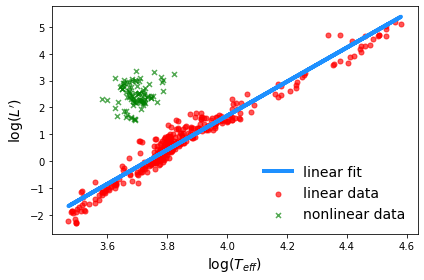

In [28]:
fig, ax = plt.subplots(1, 1)

ax.scatter(log_T[indices], log_L[indices], s = 25, c = 'red', alpha = 2/3, label = 'linear data')
ax.scatter(log_T[~indices], log_L[~indices], s = 25, c = 'green', marker = 'x', alpha = 2/3, label = 'nonlinear data')

ax.plot(log_T[indices], log_T[indices]*s + b, lw = 4, c = 'dodgerblue', label = 'linear fit')

ax.set_xlabel('$\log(T_{eff})$', fontsize = 14)
ax.set_ylabel('$\log(L\')$', fontsize = 14)
ax.legend(loc = 'lower right', fontsize = 14, frameon = False)

fig.tight_layout()

Finally, it has converged.  And, it looks correct. 

The reason why we can cluster is that we know that there is a certain behavior that exists and it is clear that this aspect of nonlinear data exists outside of the expected.  Really, it begs the question...what's special about it? 

But first, we should see our slope and compare to expect value, of course:

In [23]:
print('our slope: %s' % s)

our slope: 6.343316588367558


What? This doesn't agree with our expectation of $4$ at all... well, this is because surface area is $A = 4\pi R^2$ such that

$$R \propto M^{\dfrac{v - 1}{v + 3}}$$

where $M$ is mass and $v$ is some constant (of which that I don't know) according to [this set of notes](https://websites.pmc.ucsc.edu/~glatz/astr_112/lectures/notes14.pdf).  So, when surface area is transformed into the log space, $\dfrac{v - 1}{v + 3}$ is brought down similar to how $4$ is brought down.  

Hence, the reality is that 

$$s \propto 4\left[1 - \dfrac{2}{3}\dfrac{v - 1}{v + 3}\right]^{-1}$$

as stated in the same set of notes.  We can then analytically solve for $v$ to find out which family of stars the linear sequence belongs to, since that is what $v$ is indicative of.

---

#### TO-DO:
* create a function to solve for $v$ analytically 
* examine different properties of the non-linear and linear sequence to try to understand the separation
* cite cite cite

After that, this notebook is basically done unless something else really stands out from this data.